In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from CNN import ConvNet
import random
import matplotlib.pyplot as plt
import numpy as np

### Подготовка данных

In [11]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='animals/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root='animals/val', transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

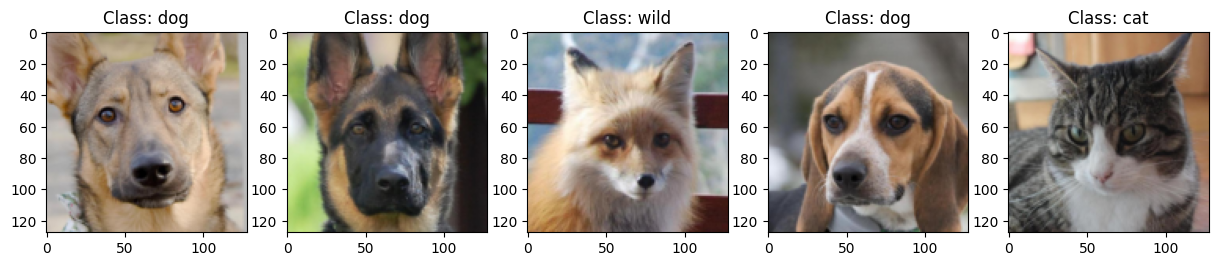

In [31]:
# Функция для отображения случайной выборки
def show_random_samples(dataset, num_samples=5):
    class_names = dataset.classes
    # Получаем случайные индексы из тренировочного датасета
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Создаем подзагрузчик данных для случайной выборки
    random_loader = DataLoader(dataset, batch_size=num_samples, sampler=SubsetRandomSampler(random_indices))

    # Получаем один батч из случайной выборки
    images, labels = next(iter(random_loader))

    # Преобразование тензоров в изображения
    images = images.numpy()

    # Вывод изображений
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i].set_title(f'Class: {class_names[labels[i].item()]}')

    plt.show()

# Используйте функцию, передавая ваш тренировочный датасет
show_random_samples(train_dataset, num_samples=5)

### Инициализация нейросети

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
from ipywidgets import IntProgress
from IPython.display import display

### Обучение нейросети

In [24]:
num_epochs = 10 # Количество эпох
progress = IntProgress(min=0, max=len(train_loader))
display(progress)

for epoch in range(num_epochs):
    progress.value = 0
    progress.description = "Epoch " + str(epoch + 1) + "/" + str(num_epochs)
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        progress.value += 1

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}')

# Сохранение модели
torch.save(model.state_dict(), 'conv_net.pth')

IntProgress(value=0, max=458)

Epoch 1/10, Loss: 0.08031851053237915, Accuracy: 0.944
Epoch 2/10, Loss: 0.013800549320876598, Accuracy: 0.9253333333333333
Epoch 3/10, Loss: 0.09528014063835144, Accuracy: 0.9446666666666667
Epoch 4/10, Loss: 0.0017160214483737946, Accuracy: 0.9406666666666667
Epoch 5/10, Loss: 0.18631067872047424, Accuracy: 0.9506666666666667
Epoch 6/10, Loss: 0.0003429069765843451, Accuracy: 0.9506666666666667
Epoch 7/10, Loss: 0.13384205102920532, Accuracy: 0.9553333333333334
Epoch 8/10, Loss: 0.0035991077311336994, Accuracy: 0.9473333333333334
Epoch 9/10, Loss: 0.03291874751448631, Accuracy: 0.952
Epoch 10/10, Loss: 0.0008642390603199601, Accuracy: 0.938


### Тестирование модели

In [47]:
model = ConvNet().to(device)
model.load_state_dict(torch.load("conv_net.pth"))
model.eval()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=3, bias=True)
)

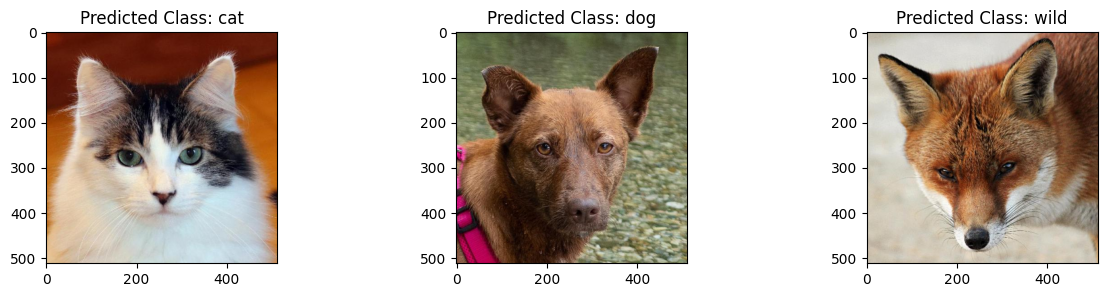

In [48]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Путь к вашему изображению
images = ['animals/val/cat/flickr_cat_000008.jpg',
          'animals/val/dog/flickr_dog_000043.jpg',
          'animals/val/wild/flickr_wild_000004.jpg']

# Загрузка изображения

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))

for image_path, i in zip(images, range(len(images))):
    image = Image.open(image_path)

    # Применение трансформаций к изображению
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    # Преобразование изображения и добавление размерности пакета
    input_image = transform(image).unsqueeze(0)

    # Передача изображения через модель
    model.eval()  # Установка модели в режим оценки (выключение режима обучения)
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)

    # Получение предсказания
    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()

    # Вывод результата
    class_names = train_dataset.classes  # Замените на свои классы
    predicted_class_name = class_names[predicted_class]

    # Вывод изображения и предсказания
    axes[i].imshow(np.asarray(image))
    axes[i].set_title(f'Predicted Class: {predicted_class_name}')
plt.show()